# Final Testing

In [1]:
from raag_midi_gen.dataset_muspy import get_dataset
from raag_midi_gen.tokenization import tokenize
from raag_midi_gen.embedding import NoteAttributeEmbedding

In [2]:
midi_files_dataset = get_dataset()
muspy_midi = midi_files_dataset['Aeri Aali - Sthaayi 1.1_2.mid'][-1]

In [3]:
position, pitch, octave, velocity, note_event_type = tokenize(muspy_midi)

In [4]:
embedder = NoteAttributeEmbedding()
embeddings = embedder(position, pitch, octave, velocity, note_event_type)
embeddings

tensor([[ 2.7738e+00,  6.8888e-01, -1.6111e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 2.7738e+00,  6.8888e-01, -1.6111e+00,  ...,  9.9987e-01,
          8.1918e-03,  9.9997e-01],
        [ 2.7738e+00,  6.8888e-01, -1.6111e+00,  ...,  9.9946e-01,
          1.6383e-02,  9.9987e-01],
        ...,
        [ 5.3798e-01, -7.9275e-01,  1.3610e-01,  ...,  9.9946e-01,
         -1.6383e-02,  9.9987e-01],
        [ 5.3798e-01, -7.9275e-01,  1.3610e-01,  ...,  9.9987e-01,
         -8.1918e-03,  9.9997e-01],
        [ 5.3798e-01, -7.9275e-01,  1.3610e-01,  ...,  1.0000e+00,
         -2.4493e-16,  1.0000e+00]], dtype=torch.float64,
       grad_fn=<CatBackward0>)

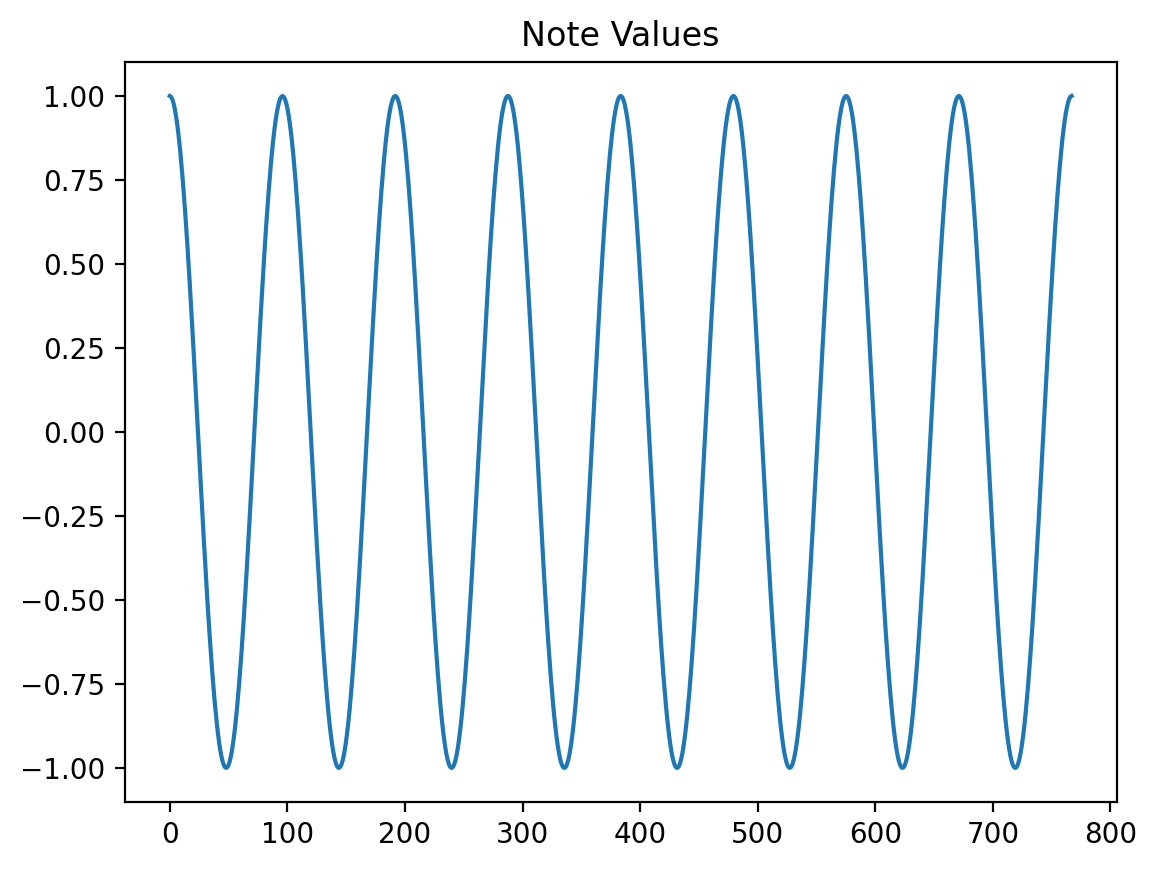

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Plot a histogram
sns.lineplot(x=np.arange(0,768),y=embeddings.detach().numpy()[:,11])
plt.title("Note Values")
plt.show()

[<Axes: xlabel='time (beat)', ylabel='\n\npitch'>]

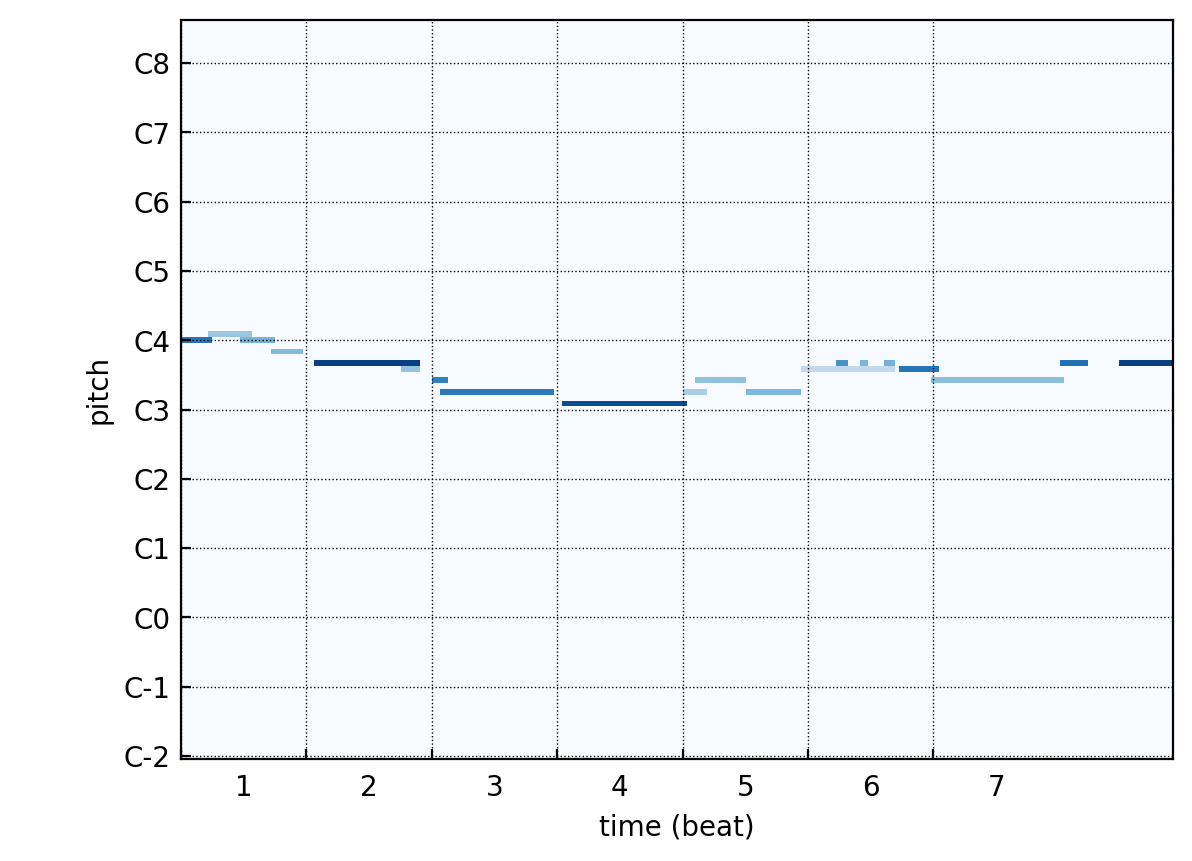

In [8]:
import muspy

muspy.show_pianoroll(test_muspy_midi)

In [13]:
a = np.array([1,2,3,4])  # [...,[0,2]]
b = np.zeros((4,1), dtype=int)

selected_positions = [0,2]

b[...,selected_positions,0] = np.mod(np.array([1,2,3,4])[...,selected_positions], 12) - 1

In [14]:
b

array([[0],
       [0],
       [2],
       [0]])

In [141]:
import math

import muspy
import torch
import numpy as np
from torch import nn

# `numpy` Preprocessing

In [142]:
from raag_midi_gen.dataset_muspy import get_dataset


midi_files_dataset = get_dataset()
test_muspy_midi = midi_files_dataset['Aeri Aali - Sthaayi 1.1_2.mid'][-1]

## APPROACH:
Convert each Muspy MIDI object to a set of numpy 2D arrays, one for each of the following:
1. `position` - 6 dimensions, based on the sin/cos computation
2. `note`   - an index in [0,12] (`0` for no note)
3. `octave` - an index in [0,12] (`0` for no note)
4. `velocity` - a float scaled from [0,127] to [0,1]
5. `note_type` - an index between [0,3]; (`0` for no note, the rest for `NOTE_ON`, `NOTE_OFF`, and `NOTE_HOLD` respectively)

### On `NOTE_HOLD` events:
Using an algorithm that iterates through the notes (sported by start position), we will insert `NOTE_HOLD`s for the last seen `NOTE_ON` event. If there are two simultaneous `NOTE_ON`/`NOTE_OFF` events, then we will move one of them ahead by one timestep.

In [169]:
import operator
from enum import Enum
from typing import NamedTuple


class EventType(Enum):
    NO_NOTE    = 0
    NOTE_ON    = 1
    NOTE_OFF   = 2
    NOTE_HOLD  = 3


class NoteEvent(NamedTuple):
    position: int
    midi_pitch: int
    velocity: int
    event_type: EventType


def separate_events(note):
    """
    Converts a muspy Note object into two NoteEvent objects, one for Note On one for Note Off

    Args:
        note: one muspy Note object, containing information on `time`, `pitch`, `duration`, and `velocity`

    Returns:
        A list of two NoteEvent objects, one for the Note On event and one for the Note Off event
        
    """
    return [
        NoteEvent(note.time,                 note.pitch, note.velocity, EventType.NOTE_ON),
        NoteEvent(note.time + note.duration, note.pitch, note.velocity, EventType.NOTE_OFF)
    ]


def insert_note_holds(note_events, length_in_ticks):
    """
    Converts a list of NOTE_ON and NOTE_OFF NoteEvents to a list of NOTE_ON, NOTE_OFF, and NOTE_HOLD NoteEvents.
    Adds NOTE_HOLDS corresponding to the latest NOTE_ON event. 

    Args:
        An input sequence of NoteEvents. This will only have NOTE_ON and NOTE_OFF events
    
    Returns:
        A sequnce of NoteEvents of length equal to the length of the entire clip (in timesteps).
        Each timestep will have either a NOTE_ON, NOTE_OFF, NOTE_HOLD, or NO_NOTE NoteEvent.
    """
    # The output is filled in with NO_NOTE NoteEvents by default
    output = [NoteEvent(position=i, midi_pitch=-1, velocity=-1, event_type=EventType.NO_NOTE) for i in range(length_in_ticks)]

    # Separate events happening at the same timestep
    # Simultaneous events at the very end of the sequence remain simultaneous
    for i in range(0,len(note_events)-1):
        if note_events[i].position == note_events[i+1].position:
            if not note_events[i+1].position == length_in_ticks-1:
                note_events[i+1].position += 1

    # Convert input note_events to deque for easier processing
    note_events = deque(note_events)

    # Keeping track of NOTE_ON and NOTE_OFF NoteEvents
    switched_on_notes = deque([])
    switched_off_notes = deque([])
    def _cancel_out_on_and_off_events():
        while switched_off_notes[-1].midi_pitch == switched_on_notes[-1].midi_pitch:
            switched_on_notes.pop()
            switched_off_notes.pop()

    # Add NOTE_HOLDs
    for i in range(length_in_ticks):
        if i == note_events[0].position:
            current_note_event = note_events.popleft()
            output[i] = current_note_event

            if current_note_event.event_type == EventType.NOTE_ON:
                switched_on_notes.append(current_note_event)        
            elif current_note_event.event_type == EventType.NOTE_OFF:
                switched_off_notes.append(current_note_event)
                _cancel_out_on_and_off_events()

        elif switched_on_notes:
            output[i] = NoteEvent(
                position=i,
                midi_pitch=switched_on_notes[-1].midi_pitch,
                velocity=switched_on_notes[-1].velocity,
                event_type=EventType.NOTE_HOLD
            )
    

    return output 

In [170]:
ticks_per_qn         =   test_muspy_midi.resolution
beats_per_measure    =   test_muspy_midi.time_signatures[0].numerator
qn_per_beat          =   4/test_muspy_midi.time_signatures[0].denominator
qn_per_measure       =   beats_per_measure*qn_per_beat

length_in_qn         =   math.ceil(test_muspy_midi.get_end_time()/test_muspy_midi.resolution)
length_in_ticks      =   length_in_qn*ticks_per_qn
length_in_beats      =   length_in_qn/qn_per_beat
length_in_measures   =   length_in_qn/qn_per_measure

note_events_without_holds = sorted([note_event for note in test_muspy_midi.tracks[0].notes for note_event in separate_events(note)], key=operator.attrgetter('position'))
note_events = insert_note_holds(note_events_without_holds, length_in_ticks)
note_event_positions = [note_event.position for note_event in note_events if not note_event.event_type == EventType.NO_NOTE]
print(note_events[0])

AttributeError: can't set attribute

In [ ]:
from collections import deque


def insert_note_holds(note_events, length_in_ticks):
    """
    
    """

    output = [NoteEvent(position=i, midi_pitch=0, velocity=0, event_type=EventType.NO_NOTE) for i in range(length_in_ticks)]

    note_events = deque(note_events)

    current_on_notes = deque([])
    for i in range(length_in_ticks):
        current_note_event = None
    
        if i == note_events[0].position:
            current_note_event = note_events.popleft()
            if current_note_event.event_type == EventType.NOTE_ON:
                current_on_notes.append(current_note_event)        
            elif current_note_event.event_type == EventType.NOTE_OFF:
                output[i] = current_note_event
        if current_on_notes
            

In [158]:
l = deque([0])

if l:
    print('True')

True


### Position

In [145]:
position = np.empty((length_in_ticks,6), dtype=float)

# Beats
position[...,0] =  np.sin(np.linspace(0, 2*np.pi*length_in_beats, length_in_ticks))
position[...,1] =  np.cos(np.linspace(0, 2*np.pi*length_in_beats, length_in_ticks))

# Measures
position[...,2] =  np.sin(np.linspace(0, 2*np.pi*length_in_measures, length_in_ticks))
position[...,3] =  np.cos(np.linspace(0, 2*np.pi*length_in_measures, length_in_ticks))

# Melody
position[...,4] = np.sin(np.linspace(0, 2*np.pi, length_in_ticks))
position[...,5] = np.cos(np.linspace(0, 2*np.pi, length_in_ticks))

In [146]:
position

array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 6.54882786e-02,  9.97853339e-01,  1.63830618e-02,
         9.99865789e-01,  8.19180578e-03,  9.99966447e-01],
       [ 1.30695395e-01,  9.91422571e-01,  3.27617261e-02,
         9.99463191e-01,  1.63830618e-02,  9.99865789e-01],
       ...,
       [-1.30695395e-01,  9.91422571e-01, -3.27617261e-02,
         9.99463191e-01, -1.63830618e-02,  9.99865789e-01],
       [-6.54882786e-02,  9.97853339e-01, -1.63830618e-02,
         9.99865789e-01, -8.19180578e-03,  9.99966447e-01],
       [-1.95943488e-15,  1.00000000e+00, -4.89858720e-16,
         1.00000000e+00, -2.44929360e-16,  1.00000000e+00]],
      shape=(768, 6))

### Note

In [147]:
note = np.zeros((length_in_ticks,1), dtype=int)

note[...,note_event_positions,0] = np.mod(np.array([note_event.midi_pitch for note_event in note_events]), 12) + 1

In [163]:
n = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])

print(np.mod(n, 12) + 1)

[ 1  2  3  4  5  6  7  8  9 10 11 12  1  2  3]


In [148]:
note

array([[ 1],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 2],
       [ 0],
       [ 0],
       [ 1],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 1],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 2],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [11],
       [ 0],
       [ 0],
       [ 1],
       [ 0],
       [ 0],
       [ 0],
       [ 0],

### Octave

In [149]:
octave = np.zeros((length_in_ticks,1), dtype=int)

octave[...,note_event_positions,0] = np.floor_divide(np.array([note_event.midi_pitch for note_event in note_events]), 12)

In [150]:
octave

array([[6],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [6],
       [0],
       [0],
       [6],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [6],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [6],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [5],
       [0],
       [0],
       [6],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

### Velocity

In [151]:
velocity = np.zeros((length_in_ticks,1), dtype=float)

velocity[...,note_event_positions,0] = np.interp(np.array([note_event.velocity for note_event in note_events]), [0,127], [0,1])

In [152]:
velocity

array([[0.73228346],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.38582677],
       [0.        ],
       [0.        ],
       [0.73228346],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.47244094],
       [0.        ],
       [0.   

### Note Type

In [153]:
note_type = np.zeros((length_in_ticks,1), dtype=int)

note_type[...,note_event_positions,0] = np.array([note_event.event_type.value for note_event in note_events])

In [154]:
note_type

array([[1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [2],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [2],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

# Create Embedding Module

In [28]:
class MultiPartEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Learnable Layer 1: Pitch
        NOTE_VOCAB_SIZE = 12
        NOTE_EMBED_DIM = 6
        self.pitch_embedder = nn.Embedding(NOTE_VOCAB_SIZE, NOTE_EMBED_DIM)
        
        # learnable Layer 2: Octaves
        OCTAVE_VOCAB_SIZE = 11
        OCTAVE_EMBED_DIM = 2
        self.octave_embedder = nn.Embedding(OCTAVE_VOCAB_SIZE, OCTAVE_EMBED_DIM)

        # Learnable Layer 3: Event Type
        EVENT_TYPE_SIZE = 2  # Note On, Note Off
        EVENT_TYPE_EMBED_DIM = 1
        self.event_type_embedder = nn.Embedding(EVENT_TYPE_SIZE, EVENT_TYPE_EMBED_DIM)

    def forward(self, note_rep: np.ndarray, length, resolution, time_sig_num, time_sig_den):
        """
        Forward pass with concatenated embeddings
        
        Args:
            note_rep: muspy note representation of a MIDI clip (a numpy ndarray with dtype np.int64).
                        It has one `[time, pitch, duration, velocity]` entry for each note.
                        The `time` and `duration` are in ticks.
            length: total length of the clip in beats (can be determined from muspy quite simply)
            resolution: PPQN (pulses per quarter note, a.k.a., ticks per quarter note)
            time_sig_num: numerator of time signature for MIDI clip
            time_sig_den: denominator of time signature for MIDI clip
        
        Returns:
            Concatenated embeddings
        """
        # Note Embedding
        pitches = note_rep[..., 1]%12
        pitch_emb = self.pitch_embedder(torch.from_numpy(pitches))

        # Octave Embedding
        octaves = note_rep[..., 1]//12 - 1
        oct_emb = self.octave_embedder(torch.from_numpy(octaves))

        # Velocity Embedding
        velocities = note_rep[...,3]
        vel_emb = torch.from_numpy(note_rep[..., 3])[...,None]/127
        
        # Duration Embedding
        dur_emb = torch.from_numpy(note_rep[..., 2])[...,None]/length
        
        # Position Embeddings (encoded at 3 different resolutions with sin and cos)
        positions = note_rep[..., 0]
        repeat_dimensions_tuple = (1,)*positions.ndim + (6,)
        pos_emb = torch.from_numpy(positions)[...,None].repeat(repeat_dimensions_tuple).float()  # create 6 copies of the start positions of the notes

        TICKS_PER_BEAT    = resolution
        W_BEAT            = 2*math.pi/TICKS_PER_BEAT
        pos_emb[...,0] = torch.sin(pos_emb[...,0]*W_BEAT)
        pos_emb[...,1] = torch.cos(pos_emb[...,1]*W_BEAT)
        
        TICKS_PER_MEASURE = resolution*((time_sig_num)/(time_sig_den/4))
        W_MEASURE         = 2*math.pi/TICKS_PER_MEASURE
        pos_emb[...,2] = torch.sin(pos_emb[...,2]*W_MEASURE)
        pos_emb[...,3] = torch.cos(pos_emb[...,3]*W_MEASURE)
        
        TICKS_PER_MELODY  = resolution*length
        W_MELODY          = 2*math.pi/TICKS_PER_MELODY
        pos_emb[...,4] = torch.sin(pos_emb[...,4]*W_MELODY)
        pos_emb[...,5] = torch.cos(pos_emb[...,5]*W_MELODY)
        
        return torch.cat([pitch_emb, oct_emb, vel_emb, dur_emb, pos_emb], dim=-1)

In [29]:
from raag_midi_gen.dataset_muspy import get_dataset


midi_files_dataset = get_dataset()
test_muspy_midi = midi_files_dataset['Aeri Aali - Sthaayi 1.1_2.mid'][-1]

embedding_module = MultiPartEmbedding()
embedding = embedding_module(
    muspy.to_note_representation(test_muspy_midi),
    math.ceil(test_muspy_midi.get_end_time()/test_muspy_midi.resolution),
    test_muspy_midi.resolution,
    test_muspy_midi.time_signatures[0].numerator,
    test_muspy_midi.time_signatures[0].denominator
)
print(type(embedding))
print(embedding.shape)
embedding

<class 'torch.Tensor'>
torch.Size([20, 16])


tensor([[-1.5790e+00,  3.5222e-01,  2.3205e-01,  1.6649e-02,  1.0943e-01,
          5.0505e-01, -1.7664e+00, -3.8185e-01,  7.3228e-01,  3.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00],
        [-1.2764e+00, -2.3301e-01,  7.7053e-01,  4.6219e-01,  1.2548e+00,
          1.1859e+00, -1.7664e+00, -3.8185e-01,  3.8583e-01,  4.1250e+00,
          9.8079e-01,  1.9509e-01,  3.3689e-01,  9.4154e-01,  1.7096e-01,
          9.8528e-01],
        [-1.5790e+00,  3.5222e-01,  2.3205e-01,  1.6649e-02,  1.0943e-01,
          5.0505e-01, -1.7664e+00, -3.8185e-01,  4.7244e-01,  3.3750e+00,
          1.9509e-01, -9.8079e-01,  6.7156e-01,  7.4095e-01,  3.5990e-01,
          9.3299e-01],
        [ 1.3023e+00, -9.4125e-02,  1.1961e+00,  2.4040e+00,  8.3894e-02,
         -6.9892e-01,  7.2114e-01, -6.4952e-01,  4.4094e-01,  3.0000e+00,
         -9.8079e-01, -1.9509e-01,  9.0399e-01,  4.2756e-01,  5.3500e-01,
          8.4485e-01],
        [-7.2721e-02

## Try With Event Based Encoding

In [10]:
from raag_midi_gen.dataset_muspy import get_dataset


midi_files_dataset = get_dataset()
test_muspy_midi = midi_files_dataset['Aeri Aali - Sthaayi 1.1_2.mid'][-1]

In [11]:
note_rep = muspy.to_note_representation(test_muspy_midi)

In [16]:
note_rep

array([[  0,  72,  24,  93],
       [ 21,  73,  33,  49],
       [ 45,  72,  27,  60],
       [ 69,  70,  24,  56],
       [102,  68,  81, 119],
       [168,  67,  15,  51],
       [192,  65,  12,  87],
       [198,  63,  87,  91],
       [291,  61,  96, 113],
       [384,  63,  18,  44],
       [393,  65,  39,  52],
       [432,  63,  42,  58],
       [474,  67,  72,  33],
       [501,  68,   9,  78],
       [519,  68,   6,  59],
       [537,  68,   9,  61],
       [549,  67,  30,  93],
       [573,  65, 102,  54],
       [672,  68,  21,  96],
       [717,  68,  42, 119]])

In [14]:
from enum import Enum

class EVENT_TYPE(Enum):
    NOTE_ON    = 0
    NOTE_OFF   = 1
    NOTE_HOLD  = 2

In [15]:
def separate_events(note):
    """
    Converts an entry from a muspy note representation to two entries,
    one for Note On one for Note Off

    Args:
        note: one entry from a muspy note representation of a MIDI clip, encoded as
                a list with values for `[timestep, midi_pitch, note_duration, note_velocity]`

    Returns:
        A list with two entries, one for the Note On event and one for the Note Off event
        Each entry will be encoded as a list of values for `[timestep, note, velocity, event_type]`
        
    """
    position = note[0]
    midi_pitch = note[1]
    duration = note[2]
    velocity = note[3]
    
    return [
        [position, midi_pitch, velocity, EVENT_TYPE.NOTE_ON.value],
        [position + duration, midi_pitch, velocity, EVENT_TYPE.NOTE_OFF.value]
    ]

np.array([
    midi_event for note in note_rep for midi_event in separate_events(note) 
])

array([[  0,  72,  93,   0],
       [ 24,  72,  93,   1],
       [ 21,  73,  49,   0],
       [ 54,  73,  49,   1],
       [ 45,  72,  60,   0],
       [ 72,  72,  60,   1],
       [ 69,  70,  56,   0],
       [ 93,  70,  56,   1],
       [102,  68, 119,   0],
       [183,  68, 119,   1],
       [168,  67,  51,   0],
       [183,  67,  51,   1],
       [192,  65,  87,   0],
       [204,  65,  87,   1],
       [198,  63,  91,   0],
       [285,  63,  91,   1],
       [291,  61, 113,   0],
       [387,  61, 113,   1],
       [384,  63,  44,   0],
       [402,  63,  44,   1],
       [393,  65,  52,   0],
       [432,  65,  52,   1],
       [432,  63,  58,   0],
       [474,  63,  58,   1],
       [474,  67,  33,   0],
       [546,  67,  33,   1],
       [501,  68,  78,   0],
       [510,  68,  78,   1],
       [519,  68,  59,   0],
       [525,  68,  59,   1],
       [537,  68,  61,   0],
       [546,  68,  61,   1],
       [549,  67,  93,   0],
       [579,  67,  93,   1],
       [573,  